**Import Tensorflow as Neural Network package**

In [18]:
import pandas as pd 
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
import tensorflow as tf

random.seed(11)
np.random.seed(11)

In [19]:
Data = pd.read_csv("../../../4 - Data/04_WorkingDatasets/Top50Combined/50MostImp+CombinedFeatures.csv")
Target = pd.read_csv("../../../4 - Data/04_WorkingDatasets/Top50CombLagged/TargetOutliersTreated.csv")

In [20]:
Target.head()

Data = Data[Data['Datum'] >= '2022-01-02 01:00:00+00:00']
Data.drop(columns = ['Datum'], inplace = True)
Data.head()


,pm10_stundenmittelwerte_ug_m3,pm2_5_stundenmittelwerte_ug_m3,PM10 [ug/m3],PM2.5 [ug/m3],NO2 [ug/m3],NOX [ug/m3 eq. NO2],no2_stundenmittelwerte_ug_m3,CPC [1/cm3],Basel Wind Direction [10 m],Basel Wind Speed [10 m],...,Basel Wind Speed [10 m]_x_Basel Wind Speed [10 m],Basel Wind Speed [10 m]_x_Basel Wind Direction [10 m],Basel Wind Speed [10 m]_x_Gasverbrauch,Basel Wind Speed [10 m]_x_Hour,Basel Wind Direction [10 m]_x_Basel Wind Direction [10 m],Basel Wind Direction [10 m]_x_Hour,406v_sumLW_x_408n_sumLief,660n_sumPW_x_Gasverbrauch,Gasverbrauch_x_Gasverbrauch,Gasverbrauch_x_Hour
25,0.369263,0.761473,0.581652,1.061620,1.256610,1.098958,-0.244049,0.507241,-0.072796,-0.273750,...,-0.419390,-0.174460,-0.285458,-0.066308,-0.899194,-0.024385,0.180482,-0.797138,-0.524208,0.076509
26,0.275948,0.699860,0.309943,0.819359,1.084468,0.836139,-0.300256,0.214210,-0.072796,-0.273750,...,-0.419390,-0.174460,-0.311684,-0.085808,-0.899194,-0.028700,-0.007376,-0.836521,-0.462041,0.126981
27,0.140982,0.567541,0.242016,0.748105,0.984806,0.773562,-0.321188,0.088324,-0.182397,-0.091965,...,-0.446583,-0.177671,-0.222522,-0.064003,-0.876278,-0.056258,0.258004,-0.803148,-0.190749,0.237890
28,-0.001124,0.466301,0.185410,0.719604,0.930446,0.992579,-0.364334,0.444500,-0.243905,0.085512,...,-0.444501,-0.219537,0.004998,-0.015965,-0.853920,-0.085714,0.156083,-0.419025,0.571741,0.464562
29,-0.061715,0.393152,0.151447,0.691103,0.821724,1.092701,-0.289761,0.314072,-0.325010,0.157978,...,-0.435517,-0.255000,0.196703,0.019188,-0.814000,-0.130792,-0.007376,-0.418860,1.440262,0.731748


In [ ]:
# Beispiel: Annahme, X.shape[0] = 1000 (1000 Zeitpunkte)
n = Data.shape[0]
X = Data.copy()
y = Target["PM10_Combined_Trend_Residual"].copy()

# Split-Größen definieren
train_size = int(n * 0.7)  # 70% Training
val_size = int(n * 0.1)    # 10% Validierung
test_size = n - train_size - val_size  # 20% Test

# Training (älteste Daten)
X_train, y_train = X[:train_size], y[:train_size]

# Validierung (neuere Daten)
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]

# Test (neueste Daten)
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


In [22]:
tf.random.set_seed(11)

model = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [24]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

In [25]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])


Epoch 1/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 38.2639 - mae: 4.2173 - mse: 35.6780 - val_loss: 33.0469 - val_mae: 3.5359 - val_mse: 30.7918
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 20.9936 - mae: 3.1724 - mse: 18.8417 - val_loss: 32.3912 - val_mae: 3.5306 - val_mse: 30.5120
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 19.0782 - mae: 3.0196 - mse: 17.2735 - val_loss: 32.3791 - val_mae: 3.5469 - val_mse: 30.7547
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 18.3107 - mae: 2.9818 - mse: 16.7439 - val_loss: 31.1663 - val_mae: 3.4970 - val_mse: 29.7463
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 17.5718 - mae: 2.9323 - mse: 16.1855 - val_loss: 30.7999 - val_mae: 3.4783 - val_mse: 29.4960
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 16.3071 - mae: 2.8577 - mse: 15.0356 - val_loss: 31.0629 - val_mae: 3.5013 - val_mse: 29.8607
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - l

In [26]:
print(X_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in X_test
print(y_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in y_test


(2456, 66)
(2456,)


In [27]:
results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.2507 - mae: 2.3734 - mse: 9.2303
Test loss, Test MAE: [10.9743013381958, 2.5284440517425537, 9.953948020935059]


In [28]:
tf.random.set_seed(11)

model2 = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model2.evaluate(X_test, y_test)
print("Test loss, Test MAE, Test MSE:", results)

Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 44.7011 - mae: 4.5801 - mse: 42.0240 - val_loss: 33.2996 - val_mae: 3.5207 - val_mse: 30.9397
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 23.2030 - mae: 3.3561 - mse: 20.9459 - val_loss: 32.5932 - val_mae: 3.5435 - val_mse: 30.6355
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 21.6185 - mae: 3.2414 - mse: 19.7312 - val_loss: 32.5974 - val_mae: 3.5577 - val_mse: 30.8864
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 19.8563 - mae: 3.1274 - mse: 18.2041 - val_loss: 32.3107 - val_mae: 3.5582 - val_mse: 30.8116
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 19.0699 - mae: 3.0973 - mse: 17.6131 - val_loss: 31.1583 - val_mae: 3.5142 - val_mse: 29.8169
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 19.3239 - mae: 3.1167 - mse: 18.0085 - val_loss: 31.4070 - val_mae: 3.5474 - val_mse: 30.1669
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 18.3077

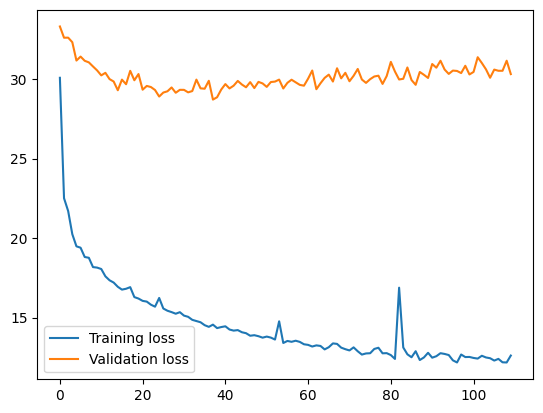

In [29]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [30]:
tf.random.set_seed(11)

model3 = Sequential([
    Dense(512, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.15),
    Dense(256, activation='relu'),
    Dropout(0.38),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='relu'),
])

optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 15 Epochen lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=15, min_lr=1e-6)



history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model3.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)



Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 35.9385 - mae: 4.0469 - mse: 33.0973 - val_loss: 33.0574 - val_mae: 3.5747 - val_mse: 30.6544
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.0527 - mae: 3.0918 - mse: 17.8008 - val_loss: 32.3860 - val_mae: 3.5586 - val_mse: 30.5144
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.8124 - mae: 3.0328 - mse: 17.0329 - val_loss: 31.8316 - val_mae: 3.5333 - val_mse: 30.2748
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 17.4708 - mae: 2.9379 - mse: 15.9688 - val_loss: 31.1683 - val_mae: 3.5168 - val_mse: 29.7785
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.8582 - mae: 2.8747 - mse: 15.5065 - val_loss: 30.5661 - val_mae: 3.4975 - val_mse: 29.2811
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.7054 - mae: 2.8792 - mse: 15.4484 - val_loss: 30.0735 - val_mae: 3.4393 - val_mse: 28.8561
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 15.7288

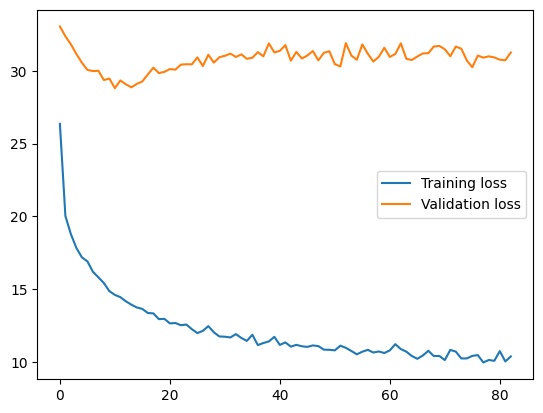

In [31]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


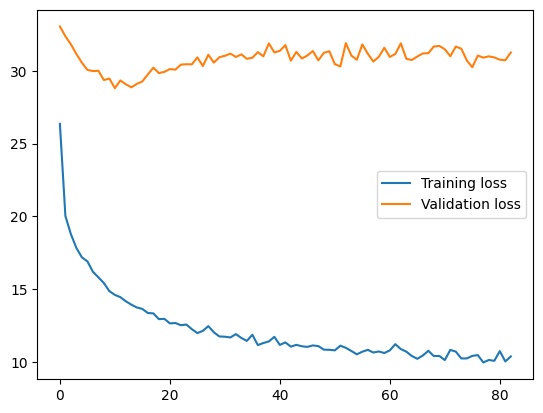

In [32]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [ ]:
tf.random.set_seed(11)

model4 = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.15),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model4.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 15 Epochen lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)


history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model4.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 56.9364 - mae: 5.1997 - mse: 53.9592 - val_loss: 34.1024 - val_mae: 3.6191 - val_mse: 31.6148
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.4825 - mae: 2.9325 - mse: 16.1701 - val_loss: 32.6611 - val_mae: 3.5660 - val_mse: 30.7405
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 17.0210 - mae: 2.8195 - mse: 15.1953 - val_loss: 32.0759 - val_mae: 3.5402 - val_mse: 30.4590
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 15.9866 - mae: 2.7589 - mse: 14.4306 - val_loss: 31.6431 - val_mae: 3.5373 - val_mse: 30.2182
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 15.3815 - mae: 2.7293 - mse: 13.9936 - val_loss: 31.3129 - val_mae: 3.5414 - val_mse: 29.9960
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 15.1394 - mae: 2.7102 - mse: 13.8490 - val_loss: 31.2052 - val_mae: 3.5568 - val_mse: 29.9546
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 15.1023